## What is Experiment Tracking?

**Experiment Tracking** is a way of tracking the models and the _Machine Learning_ experiments we are running.

So far we are tracking those experiments using Python `Dictionaries`.

It's very usefull because, If we're running lots of different experiments, experiment tracking helps us figure out what works and what doesn't.

**Experiment Tracking** is very usefull when dealing with large amount of models and experiments at once.

Other than saving the results of an experiment into a `csv file`, on a `Dictionary` or even just `printing` it we have a lot of way for performing Experiment Tracking:
* TensorBoard
* Weights & Biases Experiment Tracking
* MLFlow

(all require installation)

By searching for: `machine learning experiment tracking` we can see even more ways for tracking our experiments.

We are going to track our experiments using `torch.utils.tensorboard.SummaryWriter()` function.

- By default, the **SummaryWriter()** class saves various information about our model to a file set by the `log_dir` parameter.
- The default location for log_dir is under `runs/CURRENT_DATETIME_HOSTNAME`, where the HOSTNAME is the name of your computer.
- But of course, we can change where our experiments are tracked (the filename is as customisable as we would like).

In [75]:
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.tensorboard import SummaryWriter
from torchvision.io import read_image

import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
!pip install -q torchinfo

In [4]:
from torchinfo import summary

In [5]:
from drive.MyDrive.going_modular.going_modular import data_setup, utils
from drive.MyDrive.going_modular.going_modular.engine import accuracy_fn, training_step, validation_step

In [6]:
from collections.abc import Callable # For type hinting
from tqdm.auto import tqdm
from timeit import default_timer as timer

## Setting up Default Device

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Loading the Dataset

In [8]:
# Creating the Path Objects
dataset_path = Path("/content/drive/MyDrive/going_modular/data/pizza_steak_sushi")

train_path = dataset_path / "train"
test_path = dataset_path / "test"

## Creating the Transformations

### Manual Creation

In [9]:
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[[0.485, 0.456, 0.406]],
                         std=[0.229, 0.224, 0.225])
])

### Auto Creation

In [10]:
weight = models.EfficientNet_B0_Weights.DEFAULT

auto_transforms = weight.transforms()

## Create DataLoaders

In [11]:
BATCH_SIZE = 32

train_dl, test_dl, classes_names = data_setup.create_dataloaders(train_dir=train_path,
                                                                 test_dir=test_path,
                                                                 train_transform=auto_transforms,
                                                                 test_transform=auto_transforms,
                                                                 batch_size=BATCH_SIZE)

print(len(train_dl), len(test_dl))
print(classes_names)

8 3
['pizza', 'steak', 'sushi']


## Getting a Pre-Trained Model

In [12]:
# Getting the weights
weights = models.EfficientNet_B0_Weights.DEFAULT

# Getting the Model and move it to Device
model = models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

## Freazing `feature` Layers

In [13]:
for param in model.features.parameters():
    param.require_grad = False

## Adjusting the Ouput Layers

In [14]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(classes_names))
).to(device)

## Getting Information about the Model

In [15]:
summary(model, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## Setting Loss Function and Optimizer

In [16]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

## Using `SummaryWriter()`

In [17]:
# First we need to create a `writer` Object (the setting are going to be the defaults)
writer = SummaryWriter()

print(writer)

## Adjusting Training/Evaluating Loop

We'll get the `train()` function from `engine.py` and adjust it to use writer.

We'll add the ability for our train() function to log our model's training and test loss and accuracy values, using **writer.add_scalars(main_tag, tag_scalar_dict)**

- `main_tag`: the name for the scalars being tracked (etc "Accuracy")
- `tag_scalar_dict`: a dictionary of the values being tracked (e.g. {"train_loss": 0.3454}

For more informations about this function look: https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter

In [18]:
def fit(model: torch.nn.Module,
        epochs: int,
        train_dl: torch.utils.data.DataLoader,
        valid_dl: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        eval_metric: Callable[[torch.Tensor, torch.Tensor]],
        optim: torch.optim.Optimizer,
        n_epoch_per_print: int=1,
        n_train_batch_prints: int=None,
        n_valid_batch_prints: int=None,
        writer: torch.utils.tensorboard.writer.SummaryWriter=None):
    
    start_time = timer()
    train_losses, train_evals = [], []
    valid_losses, valid_evals = [], []

    print("Starting Process...")
    
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss, train_eval = training_step(model, train_dl, loss_fn, eval_metric, optim, n_train_batch_prints)
        valid_loss, valid_eval = validation_step(model, valid_dl, loss_fn, eval_metric, n_valid_batch_prints)

        if (n_epoch_per_print > 0) and (epoch % n_epoch_per_print == 0):
            print(
                f"-> Epoch: {epoch} | "
                f"Train Loss: {train_loss:.4f} | "
                f"Train Accuracy: {train_eval:.2f}% | "
                f"Test Loss: {valid_loss:.4f} | "
                f"Test Evaluation (%): {valid_eval:.2f}%")
            print("-" * 107)

        train_losses.append(train_loss)
        train_evals.append(train_eval)
        valid_losses.append(valid_loss)
        valid_evals.append(valid_eval)

        # Typically we are tracking our experiment when training the model
        if writer:
            batch_size, n_channels, height, width = next(iter(train_dl))[0].shape

            # Logging the Loss
            writer.add_scalars(main_tag="Loss",
                              tag_scalar_dict={"train_loss": train_loss,
                                               "valid_loss": valid_loss},
                              global_step=epoch)
            # Logging the Evaluation Metric
            writer.add_scalars(main_tag="Evaluation",
                              tag_scalar_dict={"train_eval": train_eval,
                                               "valid_eval": valid_eval},
                              global_step=epoch)
            # Track the Model Architecture
            writer.add_graph(model=model,
                             input_to_model=torch.randn(size=(batch_size, n_channels, height, width)).to(next(model.parameters()).device))
            
            # Closing the `writer`
            writer.close()


    print("Process Completed Successfully...")

    return {"model_train_loss": train_losses,
        "model_train_eval": train_evals,
        "model_valid_loss": valid_losses,
        "model_valid_eval": valid_evals,
        "model_name": model.__class__.__name__,
        "model_loss_fn": loss_fn.__class__.__name__,
        "model_evaluating_m": eval_metric.__name__,
        "model_optimizer": optim.__class__.__name__,
        "model_device": next(model.parameters()).device.type,
        "model_epochs": epochs,
        "model_time": timer() - start_time}

## Training and Evaluating the Model

In [19]:
results = fit(model, 3, train_dl, test_dl, loss_fn, accuracy_fn, opt, writer=writer, n_train_batch_prints=4)

Starting Process...


  0%|          | 0/3 [00:00<?, ?it/s]

	Looked at 64/256 training samples...
	Looked at 128/256 training samples...
	Looked at 192/256 training samples...
	Looked at 256/256 training samples...
-----------------------------------------------------------------------------------------------------------
-> Epoch: 1 | Train Loss: 0.6683 | Train Accuracy: 80.47% | Test Loss: 0.4622 | Test Evaluation (%): 87.69%
-----------------------------------------------------------------------------------------------------------
	Looked at 64/256 training samples...
	Looked at 128/256 training samples...
	Looked at 192/256 training samples...
	Looked at 256/256 training samples...
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.3767 | Train Accuracy: 85.55% | Test Loss: 0.4022 | Test Evaluation (%): 92.80%
-----------------------------------------------------------------------------------------------------------
	Looked at 64/256 training samples...
	Loo

## Viewing Model Results

The `writer` has place all the results into the folder **current_dir/runs** in TensorFlow format.

To see them in the Notebook if we have intall tensorboard (https://pypi.org/project/tensorboard/) we load it using the special command `%load_ext tensorboard` and we can view the results using `%tensorboard --logdir DIR_WITH_LOGS`

Note that needs `Allow All Cookies`...

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

## Functionalize `SummaryWriter()`

Let's create a helper function called **create_writer()** that produces a **SummaryWriter()** instance tracking to a custom `log_dir`, where log_dir could be something like: _runs/YYYY-MM-DD/experiment_name/model_name/extra_

In [20]:
def create_writer(experiment_name, model_name, extras=None):
    
    # Importing the modules that we are going to use 
    from datetime import datetime
    import os

    # Loading and formating properly the current time
    timestamp = datetime.now().strftime("%Y-%m-%d")

    # Create the `log_dir` path
    if extras:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extras)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    
    return SummaryWriter(log_dir=log_dir)

In [21]:
# Creating a Writer
example_writer = create_writer(experiment_name="data_10_percent",
                              model_name="effnetb0",
                              extras="5-epochs")

[INFO] Created SummaryWriter, saving to: runs/2023-03-17/data_10_percent/effnetb0/5-epochs...


## Setting up a Series of Modelling Experiments

A very usefull way to start is by asking what kind of experiment should we do?

There is no answer to that question. We can say, although that every `hyperparameter` stand as a good starting point for different experiments. We can:
* Change the number of epochs.
* Change the number of layers/hidden units.
* Change the amount of data.
* Change the learning rate.
* Try different kinds of data augmentation.
* Choose a different model architecture.

For the purpose of demonstration we are going to make different experiment for:
1. The amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. Different models (torchvision.models.efficientnet_b0 vs. torchvision.models. efficientnet_b2)
3. Different training time (5 epochs vs. 10 epochs)

We are going to conduct in total 8 experiments (Dataset based of Food101 -- Model -- Epochs):
1. Pizza, Steak, Sushi 10% percent -- EfficientNetB0 -- 5
2. Pizza, Steak, Sushi 10% percent -- EfficientNetB2 -- 5
3. Pizza, Steak, Sushi 10% percent -- EfficientNetB0 -- 10
4. Pizza, Steak, Sushi 10% percent -- EfficientNetB2 -- 10
5. Pizza, Steak, Sushi 20% percent -- EfficientNetB0 -- 5
6. Pizza, Steak, Sushi 20% percent -- EfficientNetB2 -- 5
7. Pizza, Steak, Sushi 20% percent -- EfficientNetB0 -- 10
8. Pizza, Steak, Sushi 20% percent -- EfficientNetB2 -- 10

**General** in our experiments we want to start `small` and `scale` things up as we go forward. Thats because, by small steps we can see what actions are not affecting the model that much.


## Preparing the Datasets

In [53]:
# Creating a function that downloads a dataset base on a git-repository (into Google Colab)
def download_data(source: str, destination: str, remove_source: bool=True):
    import requests
    import zipfile
    from pathlib import Path
    from os import remove


    # Setting the path in which the Dataset is going to be saved
    data_path = Path("/data")
    dataset_path = data_path / destination


    if dataset_path.is_dir():
        print(f"[INFO] {dataset_path} already exists, skipping download...")
    else:
        print(f"[INFO] {dataset_path} doesn't exists, creating one...")

        dataset_path.mkdir(parents=True, exist_ok=True)

        # Getting the name of the Dataset
        target_file = Path(destination).name

        with open(destination + '/' + target_file, "wb") as f:
            # Getting the raw Dataset from `github`
            req = requests.get(source)
            
            print(f"[INFO] Downloading {target_file} from {source}...")
            
            f.write(req.content)

        with zipfile.ZipFile(destination + '/' + target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file}...")
            
            # Extracting `zip_ref` to `dataset_path`
            zip_ref.extractall(dataset_path)

        # Deletting the `zip` file
        if remove_source:
            remove(destination + '/' + target_file)

        print(f"[INFO] Dataset Succesfully Downloaded in {dataset_path}")

    return dataset_path

In [55]:
# Downloading the Datasets
data_10_per_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                 destination="/content/pizza_steak_sushi")
data_20_per_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                 destination="/content/pizza_steak_sushi_20_percent")

[INFO] /content/pizza_steak_sushi already exists, skipping download...
[INFO] /content/pizza_steak_sushi_20_percent doesn't exists, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent...
[INFO] Dataset Succesfully Downloaded in /content/pizza_steak_sushi_20_percent


## Setting the Training and Testing Paths

In [56]:
train_path_10_per = data_10_per_path / "train"
train_path_20_per = data_20_per_path / "train"

# Testing path is going to be the same, because it doesn't affect the performance of the Model
test_path = data_10_per_path / "test"

# Checking the Paths
print(f"Training directory 10%: {train_path_10_per}")
print(f"Training directory 20%: {train_path_20_per}")
print(f"Testing directory: {test_path}")

Training directory 10%: /content/pizza_steak_sushi/train
Training directory 20%: /content/pizza_steak_sushi_20_percent/train
Testing directory: /content/pizza_steak_sushi/test


## Creating the Transformations and the DataLoaders

In [57]:
simple_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 32

# Creating the 10% Data Loader
train_dl_10_per, test_dl, class_names = data_setup.create_dataloaders(train_dir=train_path_10_per,
                                                                        test_dir=test_path,
                                                                        train_transform=simple_transforms,
                                                                        test_transform=simple_transforms,
                                                                        batch_size=BATCH_SIZE)
# Creating the 20% Data Loader
train_dl_20_per, _, _ = data_setup.create_dataloaders(train_dir=train_path_20_per,
                                                      test_dir=test_path,
                                                      train_transform=simple_transforms,
                                                      test_transform=simple_transforms,
                                                      batch_size=BATCH_SIZE)

# Printing the number of Batches per Data Loader
print(f"Number of batches in 10% training data: {len(train_dl_10_per)}")
print(f"Number of batches in 20% training data: {len(train_dl_20_per)}")
print(f"Number of batches in testing data: {len(test_dl)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches in 10% training data: 8
Number of batches in 20% training data: 15
Number of batches in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


## Creating the Model Functions

In [64]:
# Create the EfficientNet_B0 Model
def create_effnetb0():
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model = models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=len(class_names))
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model


# Create the EfficientNet_B2 Model
def create_effnetb2():
    weights = models.EfficientNet_B2_Weights.DEFAULT
    model = models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=len(class_names))
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

## Creating the Models

In [59]:
effnetb0 = create_effnetb0()
effnetb2 = create_effnetb2()

[INFO] Created new effnetb0 model.


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

[INFO] Created new effnetb2 model.


## Setting up Some Experiments

In [62]:
# 1. Creating an `epoch` List:
num_epochs = [5, 10]

# 2. Creating a `model` List:
model_names = ["effnetb0", "effnetb2"]

# 3. Creating `dataloader` Dictionary:
train_dataloaders = {"data_10_per": train_dl_10_per,
                     "data_20_per": train_dl_20_per}

## Conducting the Experiments

In [68]:
# 1. Keep track of experiment number
n_experiment = 0

# 2. Iterate over the Dataloaders
for train_dl_name, train_dl in train_dataloaders.items():
    
    # 3. Iterate over the Epochs
    for epochs in num_epochs:

        # 4. Iterate over the Models
        for model_name in model_names:
            
            # 5. Printing experiments details
            n_experiment += 1
            print(f"[INFO] Experiment number: {n_experiment}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {train_dl_name}")
            print(f"[INFO] Number of epochs: {epochs}\n")

            # 6. Selecting the model
            model = create_effnetb0() if (model_name == "effnetb0") else create_effnetb2()

            # 7. Setting up Loss Function and Optimizer
            loss_fn = nn.CrossEntropyLoss()
            opt = optim.Adam(model.parameters(), lr=1e-3)

            # 8. Training the Model and tracking experiments
            fit(model, epochs, train_dl, test_dl, loss_fn, accuracy_fn, opt,
                writer=create_writer(experiment_name=train_dl_name,
                                     model_name=model_name,
                                     extras=f"{epochs}_epochs"))
            
            # 9. Saving the Model
            save_path = f"/content/{model_name}_{train_dl_name}_{epochs}_epochs.pth"
            utils.save_model(model=model,
                             target_dir="models",
                             model_name=save_path)
            
            print("\n\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_per
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-03-17/data_10_per/effnetb0/5_epochs...
Starting Process...


  0%|          | 0/5 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 1.0565 | Train Accuracy: 43.75% | Test Loss: 0.8618 | Test Evaluation (%): 77.37%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.9140 | Train Accuracy: 68.36% | Test Loss: 0.7989 | Test Evaluation (%): 74.34%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.7647 | Train Accuracy: 71.09% | Test Loss: 0.6451 | Test Evaluation (%): 86.55%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.6847 | Train Accuracy: 80.86% | Test Loss: 0.5775 | Test Evaluation (%): 85.51%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.6942 | Train Accuracy: 73.83% | Test Loss: 0.5689 | Test Evaluation (%): 87.59%
----------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 1.0873 | Train Accuracy: 39.06% | Test Loss: 0.9291 | Test Evaluation (%): 69.22%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.8914 | Train Accuracy: 67.58% | Test Loss: 0.8249 | Test Evaluation (%): 76.52%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.8221 | Train Accuracy: 71.88% | Test Loss: 0.7860 | Test Evaluation (%): 76.42%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.7126 | Train Accuracy: 75.78% | Test Loss: 0.7303 | Test Evaluation (%): 80.59%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.6035 | Train Accuracy: 90.23% | Test Loss: 0.6756 | Test Evaluation (%): 85.61%
----------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 1.0523 | Train Accuracy: 44.92% | Test Loss: 0.8897 | Test Evaluation (%): 67.14%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.8736 | Train Accuracy: 62.89% | Test Loss: 0.7102 | Test Evaluation (%): 84.47%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.7602 | Train Accuracy: 69.53% | Test Loss: 0.7136 | Test Evaluation (%): 74.34%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.7014 | Train Accuracy: 71.88% | Test Loss: 0.6018 | Test Evaluation (%): 90.72%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.6504 | Train Accuracy: 77.73% | Test Loss: 0.5515 | Test Evaluation (%): 91.67%
----------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 1.0219 | Train Accuracy: 51.95% | Test Loss: 0.9715 | Test Evaluation (%): 70.17%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.9574 | Train Accuracy: 55.47% | Test Loss: 0.8819 | Test Evaluation (%): 63.16%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.7784 | Train Accuracy: 70.31% | Test Loss: 0.7922 | Test Evaluation (%): 85.61%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.7022 | Train Accuracy: 79.30% | Test Loss: 0.6942 | Test Evaluation (%): 87.59%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.6678 | Train Accuracy: 75.39% | Test Loss: 0.6915 | Test Evaluation (%): 88.64%
----------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 0.9673 | Train Accuracy: 55.00% | Test Loss: 0.6436 | Test Evaluation (%): 90.72%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.6547 | Train Accuracy: 87.08% | Test Loss: 0.5238 | Test Evaluation (%): 93.84%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.5202 | Train Accuracy: 85.83% | Test Loss: 0.4621 | Test Evaluation (%): 93.84%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.4876 | Train Accuracy: 86.67% | Test Loss: 0.4066 | Test Evaluation (%): 90.72%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.4217 | Train Accuracy: 89.38% | Test Loss: 0.3776 | Test Evaluation (%): 91.76%
----------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 0.9580 | Train Accuracy: 60.00% | Test Loss: 0.7986 | Test Evaluation (%): 80.49%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.6868 | Train Accuracy: 80.42% | Test Loss: 0.6576 | Test Evaluation (%): 90.72%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.5472 | Train Accuracy: 88.75% | Test Loss: 0.5844 | Test Evaluation (%): 90.72%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.4948 | Train Accuracy: 86.04% | Test Loss: 0.5252 | Test Evaluation (%): 91.76%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.4529 | Train Accuracy: 90.00% | Test Loss: 0.5452 | Test Evaluation (%): 85.70%
----------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 0.9670 | Train Accuracy: 60.62% | Test Loss: 0.7178 | Test Evaluation (%): 80.59%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.7296 | Train Accuracy: 80.00% | Test Loss: 0.5604 | Test Evaluation (%): 89.77%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.5983 | Train Accuracy: 84.38% | Test Loss: 0.5157 | Test Evaluation (%): 86.65%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.5095 | Train Accuracy: 85.83% | Test Loss: 0.4312 | Test Evaluation (%): 86.65%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.4284 | Train Accuracy: 89.79% | Test Loss: 0.3944 | Test Evaluation (%): 91.76%
----------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 1.0183 | Train Accuracy: 46.67% | Test Loss: 0.8221 | Test Evaluation (%): 83.43%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.7444 | Train Accuracy: 80.83% | Test Loss: 0.7137 | Test Evaluation (%): 83.52%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.6065 | Train Accuracy: 83.33% | Test Loss: 0.6054 | Test Evaluation (%): 88.64%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.4765 | Train Accuracy: 90.00% | Test Loss: 0.5739 | Test Evaluation (%): 81.53%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.4196 | Train Accuracy: 90.83% | Test Loss: 0.5074 | Test Evaluation (%): 87.69%
----------------------------

## Loading the Best Model for Predictions

In [72]:
# Setup the best model filepath
best_model_path = "/content/effnetb2_data_20_per_10_epochs.pth"

# Creating a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

## Getting the size of Model (good to know if we want to deploy it)

In [73]:
# Convert the Model size, into MB
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)

print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


## Visualize Predictions

In [98]:
# Creating the function that give us the label and the probability predicted
def get_prediction(model, label_names, image_path, model_trained_size):
    model_dtype = next(model.parameters()).dtype
    model_device = next(model.parameters()).device

    image_tensor = read_image(str(image_path)).type(model_dtype)

    resize = transforms.Resize(size=(model_trained_size, model_trained_size))
    resized_image_tensor = resize(image_tensor)

    correct_format_tensor = resized_image_tensor / resized_image_tensor.max().item()

    model.eval()
    with torch.inference_mode():
        logits = model(correct_format_tensor.unsqueeze(dim=0).to(model_device))

    pred_label = label_names[torch.softmax(logits, dim=1).argmax(dim=1)]
    label_prob = torch.softmax(logits, dim=1).max().item() * 100

    plt.imshow(image_tensor.permute(1, 2, 0).cpu().type(torch.uint8))
    plt.title(f"Label: {pred_label} | Probability: {label_prob: .2f}%")
    plt.axis(False);

In [104]:
# Getting 3 random images from the test dataset
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_path).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

print(test_image_path_sample)

[PosixPath('/content/pizza_steak_sushi/test/pizza/3092704.jpg'), PosixPath('/content/pizza_steak_sushi/test/sushi/1172255.jpg'), PosixPath('/content/pizza_steak_sushi/test/steak/2144308.jpg')]


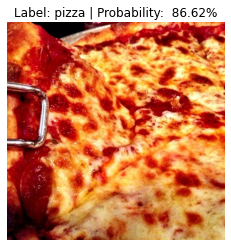

In [105]:
# Plotting the Predictions
get_prediction(model=best_model,
               label_names=class_names,
               image_path=test_image_path_sample[0],
               model_trained_size=224)

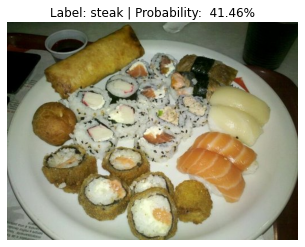

In [106]:
get_prediction(model=best_model,
               label_names=class_names,
               image_path=test_image_path_sample[1],
               model_trained_size=224)

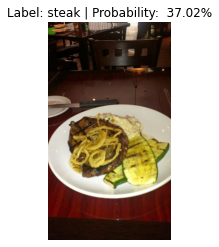

In [107]:
get_prediction(model=best_model,
               label_names=class_names,
               image_path=test_image_path_sample[2],
               model_trained_size=224)

## Finally, Let's Predict an Image that the Model has Never Seen

/content/unseen_image.jpeg already exists, skipping download.


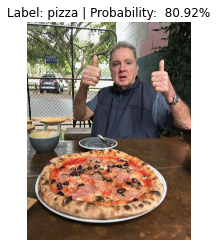

In [109]:
import requests

# Setup custom image path
custom_image_path = Path("/content/unseen_image.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
get_prediction(model=best_model,
               label_names=class_names,
               image_path=str(custom_image_path),
               model_trained_size=224)